# OSPAR Beach Litter

We start with some basic plots to understand the data better. 

In [1]:
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree
import numpy as np
from datatree import open_datatree

In [2]:
ospar = open_datatree("data/beach_litter/ospar/preprocessed.zarr", engine="zarr")
ospar = ospar["preprocessed"].to_dataset()

Did macroplastics increase on average in NEA over the years? Not so much it seems. Rather a suspicious jump at 2010 with an apparent decline.

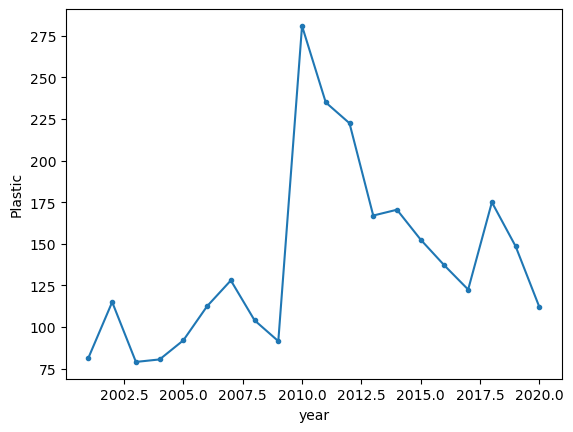

In [3]:
yearly_median = ospar.median(("beach_id", "season"))
yearly_median["Plastic"].plot(marker=".")
plt.show()

And SEA items? Similar story: sudden jump in 2010 followed by a slow decrease


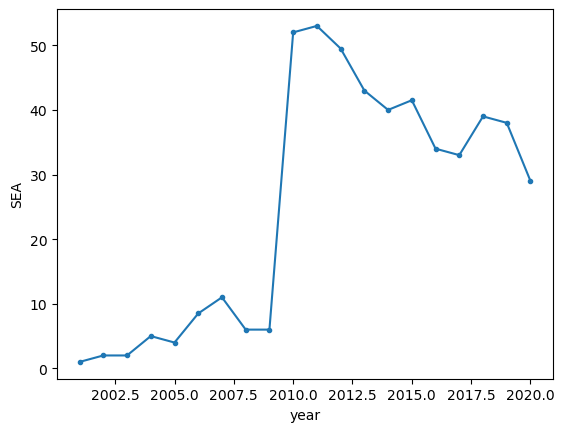

In [4]:
yearly_median["SEA"].plot(marker=".")

And aquaculture-related items? The median over all beaches is zero for all years. This indicates that less than 50% of the beaches in NEA have a number of aquaculture items different from zero for any given year. But careful! Aquaculture related items as counted by the OSPAR protocol have been shown to underestimated the real number of aquaculture items [Skirtun et al. 2022] (like by a factor 3.5 - 4.2).

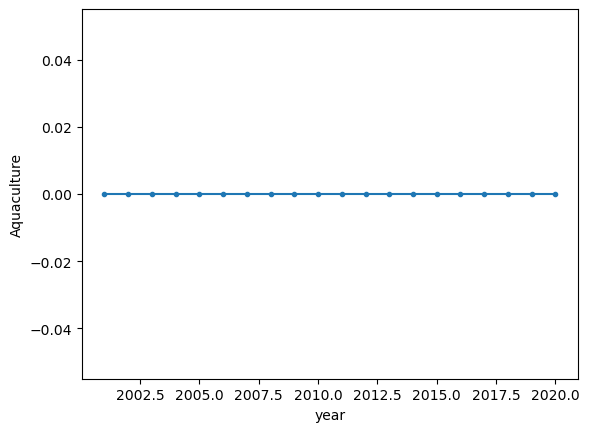

In [5]:
yearly_median["Aquaculture"].plot(marker=".")

What if we focus only on these beaches that have aquaculture items and look at the trend? For macroplastics and SEA items there doesn't seem to be a big difference. For aquaculture, we can see a slight but steady upwards trend, although very low numbers.

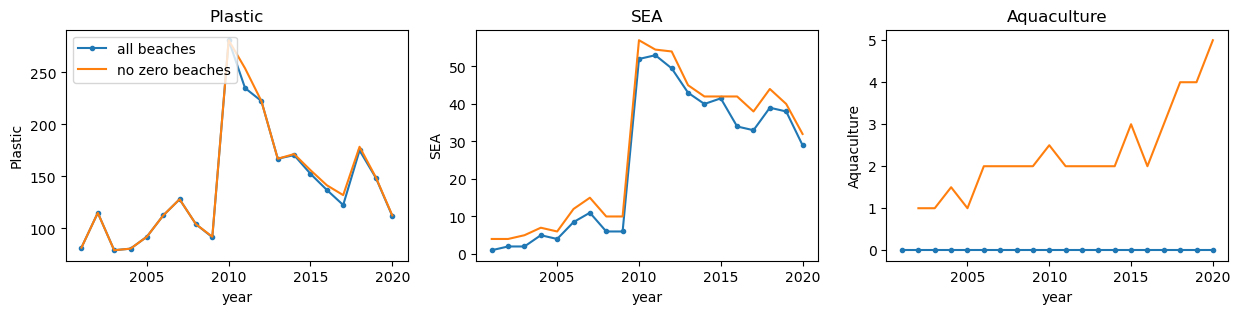

In [6]:
yearly_median_no_zero = ospar.where(ospar > 0).median(("beach_id", "season"))

fig = plt.figure(figsize=(15, 3))
axes = fig.subplots(1, 3)
for i, var in enumerate(["Plastic", "SEA", "Aquaculture"]):
    yearly_median[var].plot(ax=axes[i], marker=".", label="all beaches")
    yearly_median_no_zero[var].plot(ax=axes[i], label="no zero beaches")
    axes[i].set_title(var)
axes[0].legend(loc="upper left")

Let's look at the relative contribution of aquaculture items over time to see if the composition of plastic changed. There are two ways, first computing the mean for each year and then taking the ratio, or taking the ratio for each beach  and then computing the mean. Let's do both! 

Result: Both look comparable. Apart from the last year, the composition remained relatively stable, between 1 and 2%. 

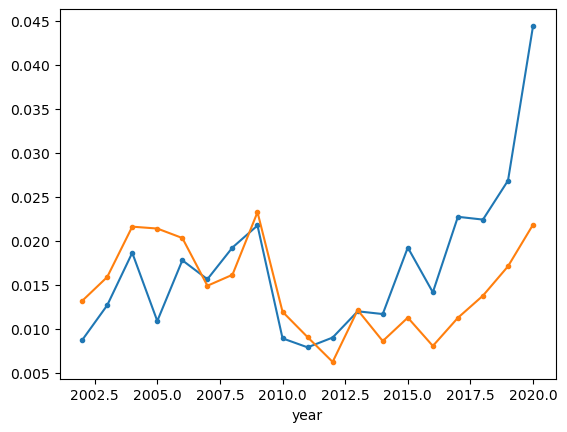

In [7]:
faqua = yearly_median_no_zero["Aquaculture"] / yearly_median_no_zero["Plastic"]
faqua.plot(marker=".")


faqua = ospar["Aquaculture"] / ospar["Plastic"]
faqua = faqua.where(faqua > 0)
faqua = faqua.median(("beach_id", "season"))
faqua.plot(marker=".")

So let's continue with the compistion because it mitigates the effect of trends.

Now we look at the spatial distribution of the composition...

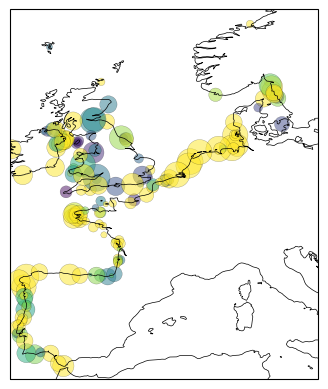

In [15]:
composition = ospar / ospar["Plastic"]
composition = composition.sel(year=slice(None, None))
composition["SEA_no_aqua"] = composition["SEA"] - composition["Aquaculture"]
composition["Aquaculture"] = 1 * composition["Aquaculture"]

is_valid = composition.notnull()
composition = composition.where(composition <= 1, 1).where(is_valid)

median_composition = composition.mean(["year", "season"])
n_counts = composition.notnull().sum(["year", "season"])



VAR = "SEA_no_aqua"
ax = plt.axes(projection=PlateCarree())
ax.coastlines(lw=0.5)
ax.scatter(
    median_composition.lon,
    median_composition.lat,
    s=5 * n_counts[VAR] ** 1,
    c=median_composition[VAR].values,
    vmin=0,
    vmax=0.2,
    cmap="viridis",
    alpha=0.5,
    ec="k",
    lw=0.2,
    transform=PlateCarree(),
)
plt.xlim(-10, 15)
plt.ylim(35, 65)
plt.show()


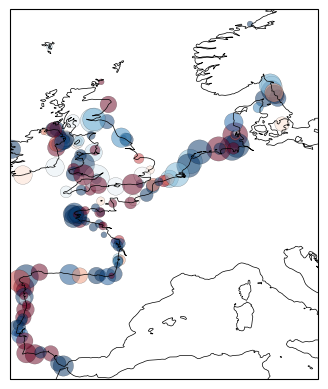

In [16]:

# %%
# Is there seasonal variation in the composition?
composition_seasonal = (composition - median_composition).mean("year")
N = composition.notnull().sum("year") ** 1
ssn = 2
ax = plt.axes(projection=PlateCarree())
ax.coastlines(lw=0.5)
ax.scatter(
    composition_seasonal.lon,
    composition_seasonal.lat,
    s=18 * N[VAR].isel(season=ssn),
    c=composition_seasonal[VAR].isel(season=ssn).values,
    vmin=-0.02,
    vmax=0.02,
    cmap="RdBu",
    alpha=0.5,
    ec="k",
    lw=0.2,
    transform=PlateCarree(),
)
plt.xlim(-10, 15)
plt.ylim(35, 65)
plt.show()



0.2196100070094928
0.23076923076923073


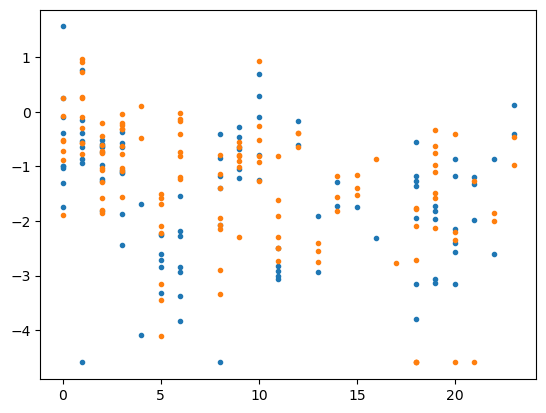

In [17]:

# %%
y = composition[VAR].sel(year=slice(2010, None))
is_valid = y.notnull()
y = y.where(y > 0.01, 0.01).where(y < 0.99, 0.99).where(is_valid)
y_trans = np.log(y / (1 - y))

ymin = 0.01
ymin_trans = np.log(y / (1 - ymin))

beaches = slice(None, None)
beaches = slice(113, 121)
beaches = (y.lat > 40) & (y.lat < 45)

plt.plot(y_trans.isel(season=0).isel(beach_id=beaches), marker=".", ls="", color="C0")
plt.plot(y_trans.isel(season=2).isel(beach_id=beaches), marker=".", ls="", color="C1")
a = y_trans.isel(season=0).isel(beach_id=beaches)
b = y_trans.isel(season=1).isel(beach_id=beaches)
# a = a.where(a > ymin_trans)
# b = b.where(b > ymin_trans)
a = a.median().item()
b = b.median().item()
print((1 / (1 + np.exp(-a))))
print((1 / (1 + np.exp(-b))))

# %%


In [18]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

for beach in y.beach_id.values:
    print(beach, inv_logit(y_trans.median("year")).round(2).sel(beach_id=beach).values)

BE001 [0.38 0.24 0.42 0.32]
BE002 [nan nan nan nan]
BE003 [0.24 0.32 0.32 0.37]
DE001 [0.39 0.41 0.3  0.38]
DE002 [ nan 0.4  0.51 0.53]
DE003 [0.58 0.69 0.62 0.7 ]
DE004 [nan nan nan nan]
DE005 [0.46 0.58 0.43 0.43]
DE006 [0.44 0.49 0.33 0.29]
DE007 [0.54 0.49 0.46 0.74]
DE008 [0.4  0.74 0.65 0.71]
DE009 [0.4  0.43 0.54 0.43]
DE10 [ nan  nan 0.25  nan]
DK001 [0.51 0.31 0.37 0.4 ]
DK004 [ nan 0.32 0.32 0.4 ]
DK006 [ nan 0.02 0.03 0.03]
DK007 [0.03 0.04 0.01 0.06]
ES001 [0.27 0.38 0.37 0.29]
ES002 [0.36 0.32 0.52 0.58]
ES003 [0.14 0.27 0.3  0.23]
ES004 [0.33 0.3  0.26 0.3 ]
ES005 [0.25 0.37 0.38 0.39]
ES006 [0.05 0.16 0.45 0.23]
ES007 [0.07 0.08 0.1  0.08]
ES008 [0.06 0.1  0.36 0.1 ]
ES009 [ nan 0.11  nan  nan]
ES010 [0.22 0.15 0.12 0.37]
ES011 [0.37 0.42 0.28 0.37]
ES012 [0.32 0.32 0.46 0.55]
ES013 [0.34 0.29 0.31 0.23]
ES014 [0.47 0.44 0.34 0.47]
FO002 [nan nan nan nan]
FR001 [nan nan nan nan]
FR002 [0.58 0.6  0.56 0.65]
FR003 [nan nan nan nan]
FR004 [0.01 0.03 0.02 0.03]
FR005 [0.24 0